# Explosion time

In [5]:
import numpy as np
from scipy.special import gamma, digamma, betainc
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
# params from original paper

# speed of mean reversion
l = 2

# mean reversion level
theta = 0.1

# vvol
xi = 0.2

# roughness, H + 1/2
alpha = 0.6

# correlation
rho = -0.8

# base variance
v0 = 0.25

# mean rev level variance
vbar = 0.2

In [7]:
# # params from el euch / rosenbaum to compare

# # speed of mean reversion
# l = 1

# # mean reversion level
# theta = 0.1

# # vvol
# xi = 1

# # roughness, H + 1/2
# alpha = 0.75

# # correlation
# rho = 0.1

# # base variance
# v0 = 0.25

In [10]:
c1 = lambda s: s * (s - 1) / 2
c2 = lambda s: rho * xi * s - l
c3 = xi ** 2 / 2

d1 = lambda u: c1(u) * c3
d2 = lambda u: c2(u)


def explosion_time(u, n):
    
    assert c1(u) > 0
    assert c2(u) / 2 >= 0
    
    v = lambda n: gamma(alpha * n + 1) / gamma(alpha * n - alpha + 1)

    a = np.array([d1(u) / v(1)])

    for i in range(1, n):
        an = (d2(u) * a[-1] + np.sum(a[:-1] * np.flip(a[:-1]))) / v(i + 1)
        a = np.append(a, [an])

    # case A, left-hand side
    if u < l / xi / rho:
        return (a[-1] * (n ** (1 - alpha)) * (gamma(alpha) ** 2) / (alpha ** alpha) / gamma(2 * alpha)) ** (
                -1 / alpha / (n + 1))
    
    # case B, right-hand side, get lower bound
    else:
        return np.abs(a[-1]) ** (-1 / alpha / n)


x = np.linspace(-16, -6, 51)
y = [explosion_time(v, 100) for v in x]

plt.plot(x, y)
plt.show()

/Users/konstantinisstarovoitovs/projects/master/venv/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars


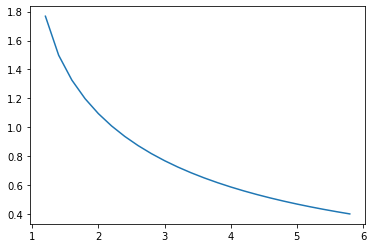

In [78]:
x = np.arange(1, 6, .2)
y = [explosion_time(v, 100) for v in x]

plt.plot(x, y)
plt.show()

# Fractional Riccati

In [137]:
# solver from El Euch, Rosenbaum

class CriticalValueError(Exception):

    def __init__(self, x, y, critical):
        self.x = x
        self.y = y
        self.critical = critical


class FRiccati:

    def __init__(self):
        self.delta = 0
        self.n = 0
        self.a = np.zeros(())
        self.b = np.zeros(())

    def _update_mat_a(self):
        
        self.a = np.zeros((self.n + 2, self.n + 2))

        for k in range(0, self.n + 1):
            for j in range(0, k + 2):
                if j == 0:
                    self.a[j, k + 1] = self.delta ** alpha / gamma(alpha + 2) * (
                            k ** (alpha + 1) - (k - alpha) * ((k + 1) ** alpha))
                elif j == k:
                    self.a[j, k + 1] = self.delta ** alpha / gamma(alpha + 2)
                else:
                    self.a[j, k + 1] = self.delta ** alpha / gamma(alpha + 2) * (
                            (k - j + 2) ** (alpha + 1) + (k - j) ** (alpha + 1) - 2 * (k - j + 1) ** (alpha + 1))
              
    def _update_mat_b(self):

        self.b = np.zeros((self.n + 2, self.n + 2))
        
        for k in range(0, self.n + 1):
            for j in range(0, k + 1):
                self.b[j, k + 1] = self.delta ** alpha / gamma(alpha + 1) * ((k - j + 1) ** alpha - (k - j) ** alpha)

    def _solve(self, p, t0, t1, n):

        @np.vectorize
        def _f(x):
            return (p ** 2 - p) / 2 + (p * rho * xi - l) * x + (xi ** 2) / 2 * (x ** 2)

        _delta = (t1 - t0) / n

        if _delta != self.delta or n != self.n:
            self.delta = _delta
            self.n = n

            # update matrices
            self._update_mat_a()
            self._update_mat_b()

        _h = np.array([0])
        _k = 1
        _t = np.linspace(t0, t1, self.n + 1)

        while _k < self.n + 1:
            hp = np.sum(self.b[0:_k, _k] * _f(_h[0:_k]))
            val = np.sum(self.a[0:_k, _k] * _f(_h[0:_k])) + self.a[_k, _k] * _f(hp)
            if val > 1e2:
                raise CriticalValueError(_t[0:_k], _h, _t[_k])
            _h = np.append(_h, val)
            _k += 1

        return _t, _h

    def critical_time(self, p, t0=0., t1=.5, n=1000):

        try:
            self._solve(p, t0, t1, n)
        except CriticalValueError as err:
            return err.critical

        return None

    def solve(self, p, t0=0., t1=1., n=1000):

        try:
            return self._solve(p, t0, t1, n)
        except CriticalValueError as err:
            return err.x, err.y

solver = FRiccati()

/Users/konstantinisstarovoitovs/projects/master/venv/lib/python3.7/site-packages/ipykernel_launcher.py:32: ComplexWarning: Casting complex values to real discards the imaginary part


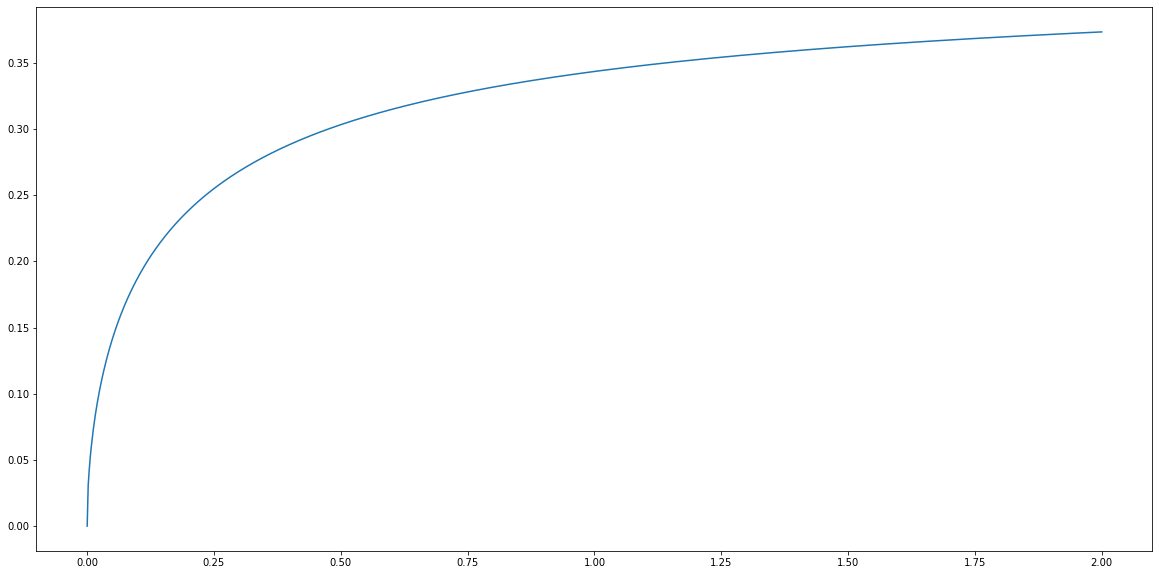

In [138]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

s = 2

x, y = solver.solve(s, t1=2)
ax.plot(x, y)

# criticals
cs = np.append(cs, x[-1])

# Constants

In [103]:
# fix explosion time and critical moment
s = 2
T = explosion_time(s, 100)

print(T)

1.0945423995781196


In [104]:
theta0 = gamma(2 * alpha) / gamma(alpha) * 2 / xi ** 2
theta1 = digamma(alpha) / gamma(alpha) * (rho * xi * s - l) / (gamma(alpha) / gamma(2 * alpha) - xi ** 2)

In [139]:
lambda0 = v0 * theta0 / gamma(1 - alpha) * (-1) * (-1) ** (2 * alpha) * betainc(2 * alpha - 1, 1 - alpha, -1)
lambda1 = v0 * theta0 / gamma(1 - alpha) * (T ** (1 - 2 * alpha) / (1 - 2 * alpha)) + vbar * l * theta0 * T ** (1 - alpha)